# pullenti-wrapper

Перед началом работы пользователь может указать язык для обработки. Это не обязательно делать, по-умолчанию, загрузятся `RU` и `EN`. Поддерживаются также `UA`, `BY`, `KZ`. В этой документации все примеры на русском, поэтому загрузим только его:

In [1]:
%%time
from pullenti_wrapper.langs import (
    set_langs,
    RU,
    EN
)

set_langs([RU])

CPU times: user 6.08 s, sys: 68.1 ms, total: 6.14 s
Wall time: 6.16 s


Затем создаётся `Processor`, в аргументах пользователь указывает, какие анализаторы будут использоваться. Доступные анализаторы описаны ниже:
- <a href="#PERSON">`PERSON`</a>
- <a href="#ORGANIZATION">`ORGANIZATION`</a>
- <a href="#GEO">`GEO`</a>
- <a href="#DATE">`DATE`</a>
- <a href="#MONEY">`MONEY`</a>
- <a href="#ADDRESS">`ADDRESS`</a>

Попробуем обработать одну статью с сайта lenta.ru, извлечём имена, организации, места и даты:

In [2]:
%%time
from pullenti_wrapper.processor import (
    Processor,
    DATE,
    GEO,
    ORGANIZATION,
    PERSON,
    MONEY,
    ADDRESS
)

processor = Processor([PERSON, ORGANIZATION, GEO, DATE])

CPU times: user 14.1 s, sys: 234 ms, total: 14.3 s
Wall time: 14.3 s


In [3]:
%%time
text = 'В США прядь волос третьего президента Соединенных Штатов Томаса Джефферсона продали на аукционе в Техасе за 6,9 тысячи долларов, передает Life. Локоны бывшего лидера США ушли с молотка почти через 190 лет после его смерти. Их покупатель пожелал остаться неизвестным. Перед началом аукциона волосы Джефферсона оценивали в 3 тысячи долларов. В январе 2015 года прядь волос 16-го президента США Авраама Линкольна продали за 25 тысяч долларов на аукционе в Далласе. Выставленную на аукцион прядь срезал начальник медицинской службы Армии США Джозеф Барнс после того, как Линкольн был застрелен 14 апреля 1865 года Джоном Бутом. Томас Джефферсон был автором Декларации независимости США и третьим президентом страны (1801-1809 годы). Авраам Линкольн — первый президент от Республиканской партии США в 1861-1865 годах, национальный герой США.'
result = processor(text)

CPU times: user 1.77 s, sys: 12.7 ms, total: 1.78 s
Wall time: 1.79 s


`result` содержит два поля:
- `text` — он может отличаться от входного `text`, например, перед обработкой из текста удаляются эмоджи
- `matches` — список подстрок с найденными сущностями

`match` состоит из:
- `referent` — структурированное описание сущности, например, для "в январе 2015 года" это `month: 1, year: 2015`
- `span` — начало, конец подстроки
- `children` — вложенные сущности, например, в "президент Соединенных Штатов Томас Джефферсон" вложены должность "президент" и место "США". Рекурсивно обойти всех `children` удобно методом `walk`:

In [4]:
# pip install ipymarkup
from ipymarkup import (
    Span,
    AsciiMarkup
)

spans = []
for match in result.walk():
    start, stop = match.span
    label = match.referent.label
    spans.append(Span(start, stop, label))
AsciiMarkup(result.text, spans)

В США прядь волос третьего президента Соединенных Штатов Томаса 
  GEO                      PERSONPROPERTY---------------        
                           PERSON-------------------------------
                                      GEO---------------        
Джефферсона продали на аукционе в Техасе за 6,9 тысячи долларов, 
                                  GEO---                         
-----------                                                      
передает Life. Локоны бывшего лидера США ушли с молотка почти через 
         ORGA         PERSONPROPERTY----                            
                                     GEO                            
190 лет после его смерти. Их покупатель пожелал остаться неизвестным. 
Перед началом аукциона волосы Джефферсона оценивали в 3 тысячи 
                              PERSON-----                      
долларов. В январе 2015 года прядь волос 16-го президента США Авраама 
            DATE------------                   PERSONPROPERTY    

У `referent` есть два поля:
- `label` — например, `'PERSON'`, `'PERSONPROPERTY'`, `'DATE'`, `'DATERANGE'`. По `label` удобно отбирать нужные сущности
- `slots` — пары `key`, `value` с аттрибутами. Некоторые пары могут повторяться например `('NAME', 'США')`, `('NAME', 'СОЕДИНЕННЫЕ ШТАТЫ')`, поэтому `slots` спиок, а не словарь: 

In [5]:
match = result.matches[1]
referent = match.referent
referent

PersonReferent(
    label='PERSON',
    slots=[Slot(
         key='SEX',
         value='MALE'
     ), Slot(
         key='LASTNAME',
         value='ТОМАС'
     ), Slot(
         key='FIRSTNAME',
         value='ДЖЕФФЕРСОН'
     ), Slot(
         key='ATTRIBUTE',
         value=PersonPropertyReferent(
             label='PERSONPROPERTY',
             slots=[Slot(
                  key='REF',
                  value=GeoReferent(
                      label='GEO',
                      slots=[Slot(
                           key='ALPHA2',
                           value='US'
                       ), Slot(
                           key='NAME',
                           value='США'
                       ), Slot(
                           key='NAME',
                           value='СОЕДИНЕННЫЕ ШТАТЫ'
                       ), Slot(
                           key='NAME',
                           value='СОЕДИНЕННЫЕ ШТАТЫ АМЕРИКИ'
                       ), Slot(
                    

В `value` иммет тип `str` ("ДЖЕФФЕРСОН", "президент", "US") или `referent`. Получается, что `referent` можно представить в виде графа:

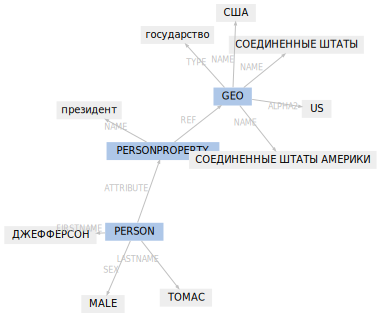

In [6]:
# install graphviz (macos: brew install graphviz)
referent.graph

Иногда неудобно выбирать из списка `value`, которые встречаются один раз:

In [7]:
first = [value for key, value in referent.slots if key == 'FIRSTNAME'][0]
last = [value for key, value in referent.slots if key == 'LASTNAME'][0]
first, last

('ДЖЕФФЕРСОН', 'ТОМАС')

Для популярных полей есть сокращения:

In [8]:
referent.firstname, referent.lastname

('ДЖЕФФЕРСОН', 'ТОМАС')

В обёртку вынесена не вся функциональность. Получить доступ к исходному объекту `pullenti` можно через поле `raw`:

In [21]:
processor.raw

In [22]:
referent.raw

## Анализаторы

In [10]:
from pullenti_wrapper.referent import Referent


def display_shortcuts(referent, level=0):
    for key in referent.__shortcuts__:
        value = getattr(referent, key)
        if value in (None, 0, -1):
            continue
        if isinstance(value, Referent):
            print('{offset}{key}:'.format(
                offset='  ' * level,
                key=key
            ))
            display_shortcuts(value, level + 1)
        else:
            print('{offset}{key}: {value!r}'.format(
                offset='  ' * level,
                key=key,
                value=value
            ))
            
            
def process_display(line, analyzers):
    processor = Processor(analyzers)
    result = processor(line)
    spans = [Span(*_.span) for _ in result.matches]
    display(AsciiMarkup(result.text, spans))

    assert len(result.matches) == 1
    referent = result.matches[0].referent
    display_shortcuts(referent)

    display(result.graph)

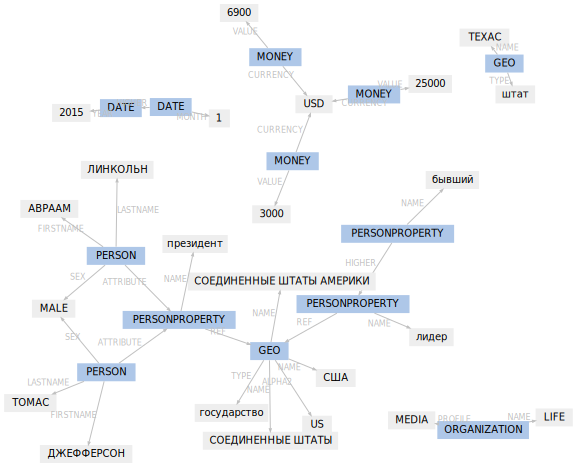

In [27]:
result.graph

### PERSON

поздравил Александра Григорьевича Лукашенко с победой
          ---------------------------------          


sex: 'MALE'
firstname: 'АЛЕКСАНДР'
middlename: 'ГРИГОРЬЕВИЧ'
lastname: 'ЛУКАШЕНКО'


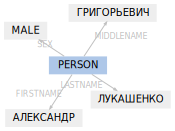

канцлер Германии Ангела Меркель
-------------------------------


sex: 'FEMALE'
firstname: 'АНГЕЛА'
lastname: 'МЕРКЕЛЬ'
attribute:
  name: 'канцлер германии'


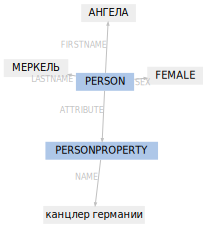

под управлением Сары Хикс
                ---------


sex: 'FEMALE'
firstname: 'САРА'
lastname: 'ХИКС'


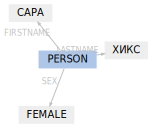

орденом князя Ярослава Мудрого V степени
        ----------------------          


sex: 'MALE'
firstname: 'ЯРОСЛАВ'
lastname: 'МУДРЫЙ'
attribute:
  name: 'князь'


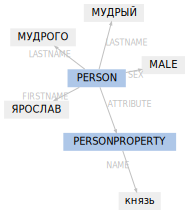

огонь благословлен Папой Римским Бенедиктом XVI
                   ----------------------------


sex: 'MALE'
firstname: 'БЕНЕДИКТ'
nickname: 'XVI'
attribute:
  name: 'папа римский'


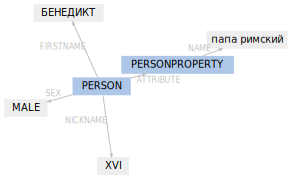

13 ноября 30-летняя главный бухгалтер Наталья Заец
          ----------------------------------------


sex: 'FEMALE'
firstname: 'НАТАЛЬЯ'
lastname: 'ЗАЕЦ'
attribute:
  name: 'главный бухгалтер'
age: 30


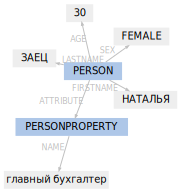

In [11]:
lines = [
    'поздравил Александра Григорьевича Лукашенко с победой',
    'канцлер Германии Ангела Меркель',
    'под управлением Сары Хикс',
    'орденом князя Ярослава Мудрого V степени',
    'огонь благословлен Папой Римским Бенедиктом XVI',
    '13 ноября 30-летняя главный бухгалтер Наталья Заец',
]

for line in lines:
    process_display(line, [PERSON])

Анатолий Ананьев родился 18 июля 1925 года в городе Джамбуле
------------------------------------------                  


sex: 'MALE'
firstname: 'АНАТОЛИЙ'
lastname: 'АНАНЬЕВ'
born:
  as_datetime: datetime.datetime(1925, 7, 18, 0, 0)
  century: 20
  year: 1925
  month: 7
  day: 18
  higher:
    century: 20
    year: 1925
    month: 7
    higher:
      century: 20
      year: 1925


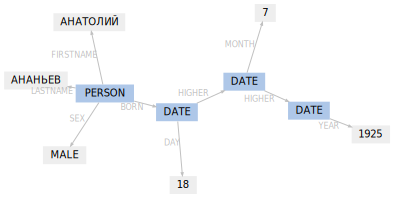

мультипликатор Роберт Саакянц, скончавшийся 24 сентября
               ----------------------------------------


sex: 'MALE'
firstname: 'РОБЕРТ'
lastname: 'СААКЯНЦ'
die:
  month: 9
  day: 24
  higher:
    month: 9


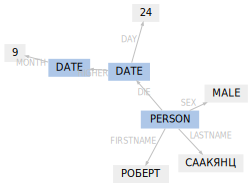

In [12]:
lines = [
    'Анатолий Ананьев родился 18 июля 1925 года в городе Джамбуле',
    'мультипликатор Роберт Саакянц, скончавшийся 24 сентября',
]

for line in lines:
    process_display(line, [PERSON, DATE])

младшей дочери президента Узбекистана Лоле Каримовой
----------------------------------------------------


name: 'младший дочь'
ref:
  sex: 'FEMALE'
  firstname: 'ЛОЛА'
  lastname: 'КАРИМОВА'
  attribute:
    name: 'президент'
    ref:
      name: 'РЕСПУБЛИКА УЗБЕКИСТАН'
      type: 'государство'
      alpha2: 'UZ'


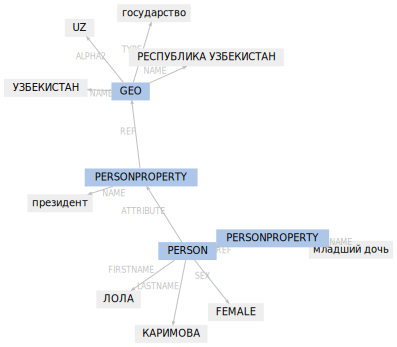

официального представителя Следственного комитета Владимира Маркина
-------------------------------------------------------------------


sex: 'MALE'
firstname: 'ВЛАДИМИР'
lastname: 'МАРКИН'
attribute:
  name: 'официальный представитель'
  ref:
    type: 'комитет'
    profile: 'STATE'


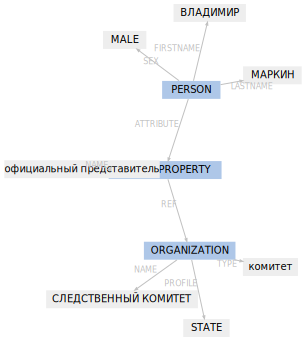

In [13]:
lines = [
    'младшей дочери президента Узбекистана Лоле Каримовой',
    'официального представителя Следственного комитета Владимира Маркина',
]

for line in lines:
    process_display(line, [PERSON, GEO, ORGANIZATION])

### ORGANIZATION

госпитализирован в московскую больницу № 7 вечером
                   -----------------------        


type: 'больница'
number: '7'
profile: 'MEDICINE'


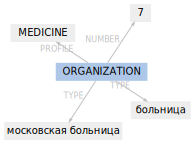

в войсковой части 3419
  --------------------


type: 'войсковая часть'
number: '3419'
profile: 'ARMY'


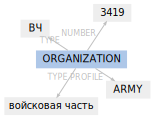

отправлен в НИИ хирургии имени Вишневского в Москву
            ------------------------------         


type: 'НИИ'
eponym: 'Вишневского'
profile: 'SCIENCE'


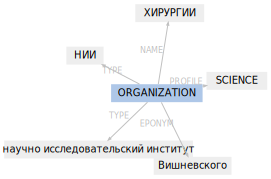

ждународного центра МГУ в Женеве
                    ---         


type: 'университет'
eponym: 'Ломоносова'
profile: 'Education'


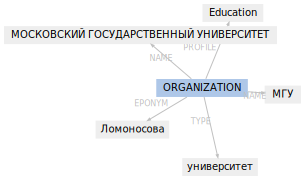

ученого совета Санкт-Петербургского физико-технического института 
------------------------------------------------------------------
имени Иоффе
-----------


type: 'ученый совет'
higher:
  type: 'институт'
  eponym: 'Иоффе'
  profile: 'EDUCATION'
profile: 'UNIT'


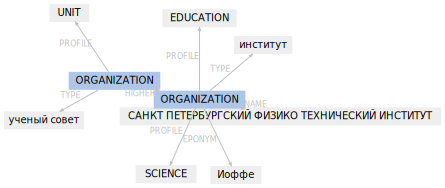

в сотрудничестве с Европейским космическим агентством (ESA)
                   ----------------------------------------


type: 'агентство'
misc: 'ESA'


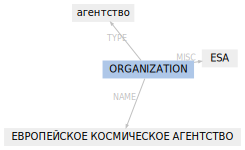

In [14]:
lines = [
    'госпитализирован в московскую больницу № 7 вечером',
    'в войсковой части 3419',
    'отправлен в НИИ хирургии имени Вишневского в Москву',
    'ждународного центра МГУ в Женеве',
    'ученого совета Санкт-Петербургского физико-технического института имени Иоффе',
    'в сотрудничестве с Европейским космическим агентством (ESA)',
]

for line in lines:
    process_display(line, [ORGANIZATION])

Санкт-Петербургское отделение «Справедливой России»
---------------------------------------------------


type: 'отделение'
higher:
  type: 'партия'
  geo:
    name: 'РФ'
    type: 'государство'
    alpha2: 'RU'
  profile: 'Policy'
geo:
  name: 'САНКТ-ПЕТЕРБУРГ'
  type: 'город'
profile: 'UNIT'


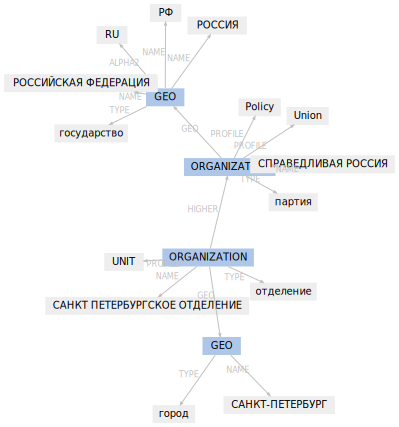

МЧС республики Бибилов
----------------------


type: 'министерство'
geo:
  name: 'БИБИЛОВ'
  type: 'республика'
profile: 'State'


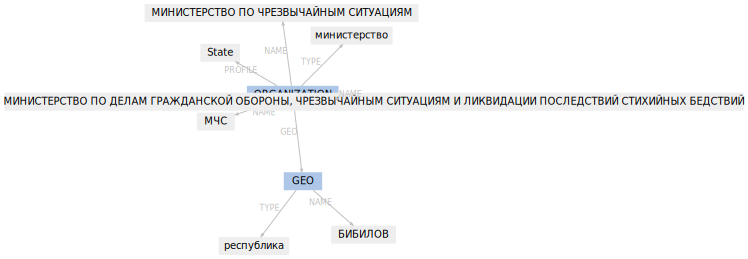

сборная Бразилии пробилась в финал
----------------                  


type: 'сборная'
geo:
  name: 'ФЕДЕРАТИВНАЯ РЕСПУБЛИКА БРАЗИЛИЯ'
  type: 'государство'
  alpha2: 'BR'
profile: 'SPORT'


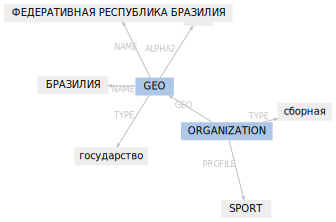

In [15]:
lines = [
    'Санкт-Петербургское отделение «Справедливой России»',
    'МЧС республики Бибилов',
    'сборная Бразилии пробилась в финал',
]

for line in lines:
    process_display(line, [ORGANIZATION, GEO])

### GEO

в поселке Березовка Уйского района
  --------------------------------


name: 'БЕРЕЗОВКА'
type: 'поселок'
higher:
  name: 'УЙСКИЙ'
  type: 'район'


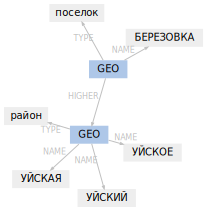

на площади города Дарджилинг на востоке Индии
           ----------------------------------


name: 'ДАРДЖИЛИНГ'
type: 'город'
higher:
  name: 'РЕСПУБЛИКА ИНДИЯ'
  type: 'государство'
  alpha2: 'IN'


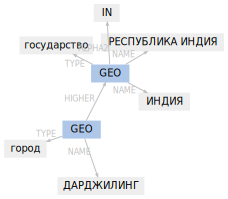

появилась в селе Райлив (Стрыйского района Львовской области)
            ------------------------------------------------ 


name: 'РАЙЛИТЬ'
type: 'село'
higher:
  name: 'СТРЫЙСКИЙ'
  type: 'район'
  higher:
    name: 'ЛЬВОВСКАЯ'
    type: 'область'


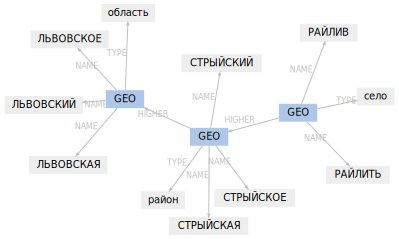

In [16]:
lines = [
    'в поселке Березовка Уйского района',
    'на площади города Дарджилинг на востоке Индии',
    'появилась в селе Райлив (Стрыйского района Львовской области)'
]

for line in lines:
    process_display(line, [GEO])

### DATE

15 сентября 2009 года
---------------------


as_datetime: datetime.datetime(2009, 9, 15, 0, 0)
century: 21
year: 2009
month: 9
day: 15
higher:
  century: 21
  year: 2009
  month: 9
  higher:
    century: 21
    year: 2009


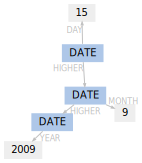

во вторник, 24 февраля
   -------------------


month: 2
day: 24
day_of_week: 2
higher:
  month: 2


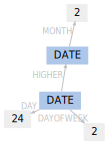

покинет свой пост летом 2014 года
                  ---------------


century: 21
year: 2014
higher:
  century: 21
  year: 2014
pointer: 'SUMMER'


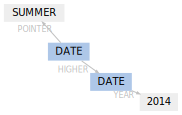

В 13.20 работа сервисов была
  -----                     


hour: 13
minute: 20


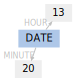

С понедельника 10-го февраля с 7 утра ты услышишь
  -----------------------------------            


month: 2
day: 10
day_of_week: 1
hour: 7
higher:
  month: 2
  day: 10
  day_of_week: 1
  higher:
    month: 2


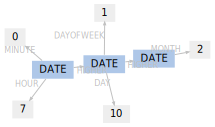

в середине августа написавших открытое
  ----------------                    


month: 8
higher:
  month: 8
pointer: 'CENTER'


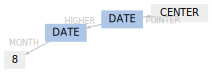

In [17]:
lines = [
    '15 сентября 2009 года',
    'во вторник, 24 февраля',
    'покинет свой пост летом 2014 года',
    'В 13.20 работа сервисов была',
    'С понедельника 10-го февраля с 7 утра ты услышишь',
    'в середине августа написавших открытое',
]

for line in lines:
    process_display(line, [DATE])

будет продлен до 2025 года
              ------------


from_:
  century: 21
  year: 2025


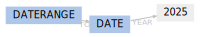

в 2008-2011 годах
  ---------------


from_:
  century: 21
  year: 2011
to:
  century: 21
  year: 2008


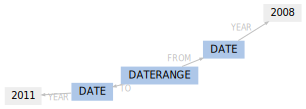

с января по май 2007 года преступник
-------------------------           


from_:
  century: 21
  year: 2007
  month: 5
  higher:
    century: 21
    year: 2007
to:
  century: 21
  year: 2007
  month: 1
  higher:
    century: 21
    year: 2007


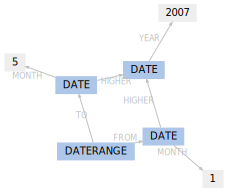

отправиться в Ирак до конца мая
                   ------------


from_:
  month: 5
  higher:
    month: 5
  pointer: 'END'


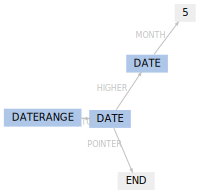

по итогам 26-29 декабря
          -------------


from_:
  month: 12
  day: 29
  higher:
    month: 12
to:
  month: 12
  day: 26
  higher:
    month: 12


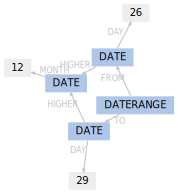

ансамбля XIX-XX веков
         ------------


from_:
  century: 20
to:
  century: 19


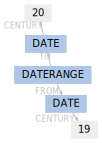

по итогам первого полугодия 2014 года доля
          ---------------------------     


from_:
  century: 21
  year: 2014
  month: 6
  higher:
    century: 21
    year: 2014
to:
  century: 21
  year: 2014
  month: 1
  higher:
    century: 21
    year: 2014


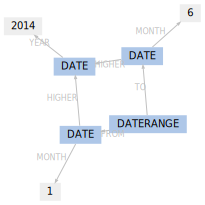

во втором квартале 2011 планируется
   --------------------            


from_:
  century: 21
  year: 2011
  month: 6
  higher:
    century: 21
    year: 2011
to:
  century: 21
  year: 2011
  month: 4
  higher:
    century: 21
    year: 2011


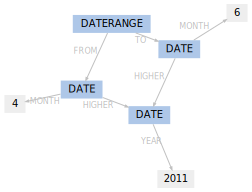

In [18]:
lines = [
    'будет продлен до 2025 года',
    'в 2008-2011 годах',
    'с января по май 2007 года преступник',
    'отправиться в Ирак до конца мая',
    'по итогам 26-29 декабря',
    'ансамбля XIX-XX веков',
    'по итогам первого полугодия 2014 года доля',
    'во втором квартале 2011 планируется',
]

for line in lines:
    process_display(line, [DATE])

### MONEY

инвестиций в 490 миллиардов рублей
             ---------------------


currency: 'RUB'
value: 490000000000
real_value: 490000000000.0


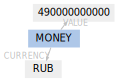

составляет пять миллионов евро
           -------------------


currency: 'EUR'
value: 5000000
real_value: 5000000.0


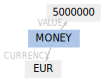

около 63 тысяч рублей
      ---------------


currency: 'RUB'
value: 63000
real_value: 63000.0


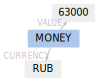

в размере десяти миллионов рублей
          -----------------------


currency: 'RUB'
value: 10000000
real_value: 10000000.0


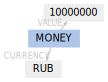

составляет 99 фунтов стерлингов
           --------------------


currency: 'GBP'
value: 99
real_value: 99.0


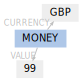

до 1,32 доллара за акцию
   ------------         


currency: 'USD'
value: 1
rest: 32
real_value: 1.32


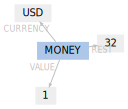

5 руб. 50 коп.
--------------


currency: 'RUB'
value: 5
rest: 50
real_value: 5.5


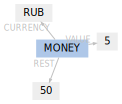

In [19]:
lines = [
    'инвестиций в 490 миллиардов рублей',
    'составляет пять миллионов евро',
    'около 63 тысяч рублей',
    'в размере десяти миллионов рублей',
    'составляет 99 фунтов стерлингов',
    'до 1,32 доллара за акцию',
    '5 руб. 50 коп.',
]

for line in lines:
    process_display(line, [MONEY])

### ADDRESS

119991 г. Москва, ул. Ленинские горы, вл.1, стр.75 В.
---------------------------------------------------- 


street:
  type: 'улица'
  name: 'ЛЕНИНСКИЕ ГОРЫ'
  geo:
    name: 'МОСКВА'
    type: 'город'
house: '1'
house_type: 'ESTATE'
building: '75В'
zip: '119991'


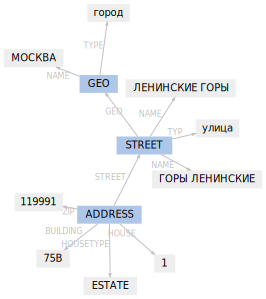

г. Москва, ул. Рябиновая, вл.20, соор.1
---------------------------------------


street:
  type: 'улица'
  name: 'РЯБИНОВАЯ'
  geo:
    name: 'МОСКВА'
    type: 'город'
house: '20'
house_type: 'ESTATE'
building: '1'
building_type: 'CONSTRUCTION'


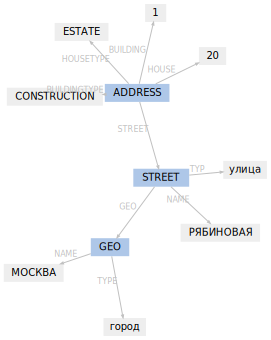

Адрес: г. Нижний Новгород, Канавинский район, Мещерский бульвар, д. 7,
----------------------------------------------------------------------
 корп. 2, оф. 12.
---------------- 


street:
  type: 'бульвар'
  name: 'МЕЩЕРСКИЙ'
  geo:
    name: 'КАНАВИНСКИЙ'
    type: 'район'
    higher:
      name: 'НИЖНИЙ НОВГОРОД'
      type: 'город'
house: '7'
corpus: '2'
office: '12'


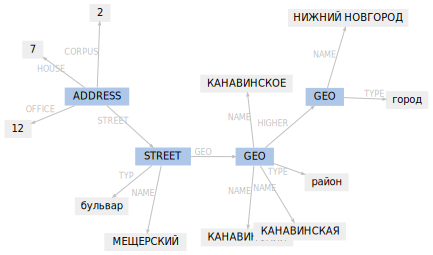

Варшавское шоссе, д.77, к. 2
----------------------------


street:
  type: 'шоссе'
  name: 'ВАРШАВСКОЕ'
house: '77'
corpus_or_flat: '2'


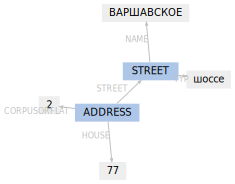

Мажоров переулок, д. 7а, 1й подъезд
-----------------------------------


street:
  type: 'переулок'
  name: 'МАЖОРОВ'
house: '7А'
porch: '1'


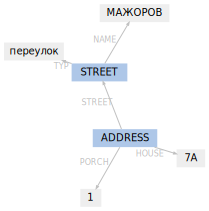

проспект Московский, д. 4, 5 этаж, офис 5
-----------------------------------------


street:
  type: 'проспект'
  name: 'МОСКОВСКИЙ'
house: '4'
floor: '5'
office: '5'


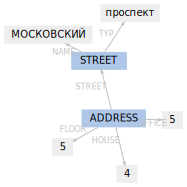

пр-кт Хасана Туфана, д. 22/9, кв. 209
-------------------------------------


street:
  type: 'проспект'
  name: 'ХАСАНА ТУФАНА'
house: '22/9'
flat: '209'


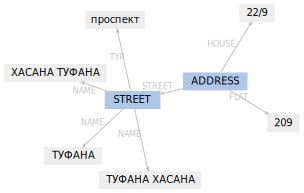

л. Б. Семеновская, д. 40, стр. 5, блок 2
   -------------------------------------


street:
  type: 'улица'
  name: 'БОЛЬШАЯ СЕМЕНОВСКАЯ'
house: '40'
building: '5'
block: '2'


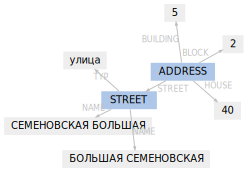

МО, г.Химки, пр-т Юбилейный, строение 6а, пом.19, комн.2
--------------------------------------------------------


street:
  type: 'проспект'
  name: 'ЮБИЛЕЙНЫЙ'
  geo:
    name: 'ХИМКИ'
    type: 'город'
    higher:
      name: 'МОСКОВСКАЯ'
      type: 'область'
building: '6А'
office: '2'
box: '19'


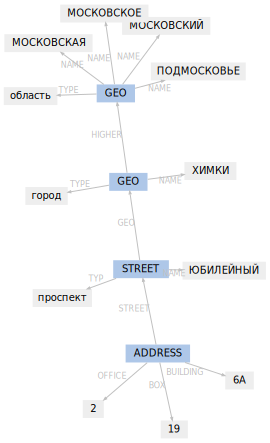

ул. Милашенкова, 4а, корп.1, а/я 52
-----------------------------------


street:
  type: 'улица'
  name: 'МИЛАШЕНКОВА'
house: '4А'
corpus: '1'
postoffice_box: '52'


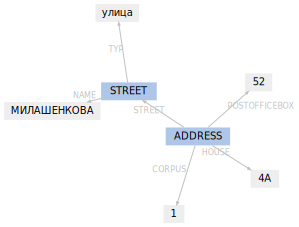

Адрес: 127994, ГСП-4, Москва, Малый Путинковский пер., д.1/2.
------------------------------------------------------------ 


street:
  type: 'переулок'
  name: 'МАЛЫЙ ПУТИНКОВСКИЙ'
  geo:
    name: 'МОСКВА'
    type: 'город'
house: '1/2'
zip: '127994'


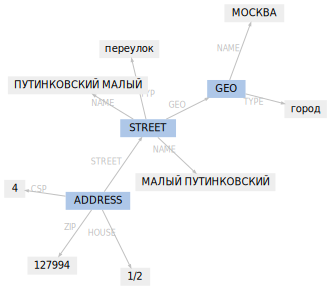

ул. 3-я Тверская-Ямская, д. 12, корп. 1
---------------------------------------


street:
  type: 'улица'
  name: 'ТВЕРСКАЯ ЯМСКАЯ'
  number: '3'
house: '12'
corpus: '1'


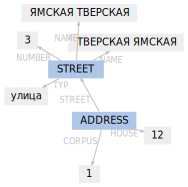

4-ая улица 8 Марта, д.3
-----------------------


street:
  type: 'улица'
  name: 'МАРТА'
  number: '4'
  second_number: '8'
house: '3'


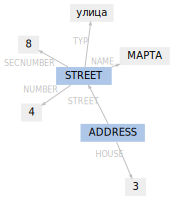

In [20]:
lines = [
    '119991 г. Москва, ул. Ленинские горы, вл.1, стр.75 В.',
    'г. Москва, ул. Рябиновая, вл.20, соор.1',
    'Адрес: г. Нижний Новгород, Канавинский район, Мещерский бульвар, д. 7, корп. 2, оф. 12.',
    'Варшавское шоссе, д.77, к. 2',
    'Мажоров переулок, д. 7а, 1й подъезд',
    'проспект Московский, д. 4, 5 этаж, офис 5',
    'пр-кт Хасана Туфана, д. 22/9, кв. 209',
    'л. Б. Семеновская, д. 40, стр. 5, блок 2',
    'МО, г.Химки, пр-т Юбилейный, строение 6а, пом.19, комн.2',
    'ул. Милашенкова, 4а, корп.1, а/я 52',
    'Адрес: 127994, ГСП-4, Москва, Малый Путинковский пер., д.1/2.',
    'ул. 3-я Тверская-Ямская, д. 12, корп. 1',
    '4-ая улица 8 Марта, д.3',
]

for line in lines:
    process_display(line, [GEO, ADDRESS])